# World Happiness Classification Competition
Goals :
- Understand how the models function
- Understand what the parameters control
- Learn from the model experimentation process
- Make a good looking notebook report
- Upload as a personal project on Github

**Overall Steps:**
1. Load datasets and merge them.
2. Preprocess data using Sklearn Column Transformer/ Write and Save Preprocessor function
3. Fit model on preprocessed data and save preprocessor function and model
4. Generate predictions from X_test data and submit predictions

## 1. Executive Summary
**Project Overview:**

This project analyzes the World Happiness Report 2023 dataset to build machine learning models that classify countries into five happiness categories: Very Low, Low, Average, High, and Very High. We want to understand which socioeconomic factors most strongly predict national happiness levels and to compare the performance and interpretability of various machine learning approaches.

**The analysis involved:**

Data preprocessing: Merging happiness data with additional country-level variables, handling missing values, feature engineering, and standardization

Feature engineering: Creating log transformations (GDP, poverty, population) and interaction features (social_freedom = social_support × freedom_to_make_life_choices)

Model development: Training and comparing models including Random Forest, SVM and Deep Neural Networks

Model explainability: Using SHAP (SHapley Additive exPlanations) to interpret feature importance and validate model decisions

**Key Findings:**

Model Performance:

- Neural Network with SGD optimizer: 50.00% test accuracy

- Random Forest with GridSearchCV: 54.76% test accuracy

- Support Vector Machine (SVM): 54.76% test accuracy

Important Features (from SHAP analysis):

- `social_support`
- `social_freedom`
- `log_gdp`
- `gni`

**Key Insights:**
- The interaction feature `social_freedom` (social_support × freedom_to_make_life_choices) ranked among the top 2 most important features in SHAP analysis, demonstrating that combining related variables can capture meaningful patterns better than individual features alone
- Random Forest and SVM achieved identical best performance (54.76% test accuracy), while the Neural Network underperformed at 50.00% accuracy. This suggests that for this small dataset (~95 samples), simpler models with proper hyperparameter tuning (GridSearchCV) are more effective than deep learning approaches
- The Neural Network exhibited severe overfitting, achieving 100% training accuracy but only 50% test accuracy (50% gap), while Random Forest and SVM showed better generalization. This highlights that neural networks require larger datasets or stronger regularization to perform well
- Random Forest and SVM offer the best balance of accuracy and interpretability for this classification task.

In [35]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns  # optional; remove if you won't use it

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import shap

# 2. Data loading and Preprocessing

In [2]:
whr_df = pd.read_csv('WHR_2023.csv')

whr_df.head()

,country,region,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption
0,Finland,Western Europe,7.804,1.888,1.585,0.535,0.772,0.126,0.535
1,Denmark,Western Europe,7.586,1.949,1.548,0.537,0.734,0.208,0.525
2,Iceland,Western Europe,7.530,1.926,1.620,0.559,0.738,0.250,0.187
3,Israel,Middle East and North Africa,7.473,1.833,1.521,0.577,0.569,0.124,0.158
4,Netherlands,Western Europe,7.403,1.942,1.488,0.545,0.672,0.251,0.394


In [3]:
whr_df['happiness_category'] = pd.qcut(whr_df['happiness_score'],
                                       q=5,
                                       labels=['Very Low', 'Low','Average', 'High', 'Very High'])

X = whr_df.drop(columns=['happiness_score', 'happiness_category'])
y = whr_df['happiness_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

y_train_labels = y_train.astype('category').cat.codes
y_test_labels = y_test.astype('category').cat.codes

In [4]:
countrydata=pd.read_csv("newcountryvars.csv")

countrydata.head()

,country_name,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni
0,India,1339180127,21.9,0.623559,68.322,11.696590,6.298834,5663.474799
1,Nigeria,190886311,70.0,0.527105,53.057,9.970482,6.000000,5442.901264
2,Mexico,129163276,46.2,0.761683,76.972,13.299090,8.554985,16383.106680
3,Pakistan,197015955,29.5,0.550354,66.365,8.106910,5.089460,5031.173074
4,Bangladesh,164669751,31.5,0.578824,71.985,10.178706,5.241577,3341.490722


In [5]:
X_train = X_train.merge(countrydata,
                        left_on='country',
                        right_on='country_name',
                        how='left')

X_test = X_test.merge(countrydata,
                      left_on='country',
                      right_on='country_name',
                      how='left')

X_train.head(1)

,country,region,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,country_name,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni
0,Madagascar,Sub-Saharan Africa,0.632,0.779,0.178,0.187,0.177,0.134,Madagascar,25570895.0,70.7,0.512149,65.515,10.34614,6.145955,1319.699397


# 3. Exploratory Data Analysis

In [6]:
print(X_train.dtypes)

country                           object
region                            object
gdp_per_capita                   float64
social_support                   float64
healthy_life_expectancy          float64
freedom_to_make_life_choices     float64
generosity                       float64
perceptions_of_corruption        float64
country_name                      object
population                       float64
population_below_poverty_line    float64
hdi                              float64
life_expectancy                  float64
expected_years_of_schooling      float64
mean_years_of_schooling          float64
gni                              float64
dtype: object


In [7]:
missing_count = X_train.isna().sum()

missing_percentage = (X_train.isna().sum()/len(X_train))*100

missing_data = pd.DataFrame({
    'Missing_Count': missing_count,
    'Missing_Percentage': missing_percentage
})

missing_data = missing_data.sort_values('Missing_Count', ascending=False)

missing_data[missing_data['Missing_Count']>0]

,Missing_Count,Missing_Percentage
population_below_poverty_line,16,16.842105
life_expectancy,7,7.368421
mean_years_of_schooling,7,7.368421
expected_years_of_schooling,7,7.368421
gni,7,7.368421
population,6,6.315789
hdi,6,6.315789
country_name,6,6.315789


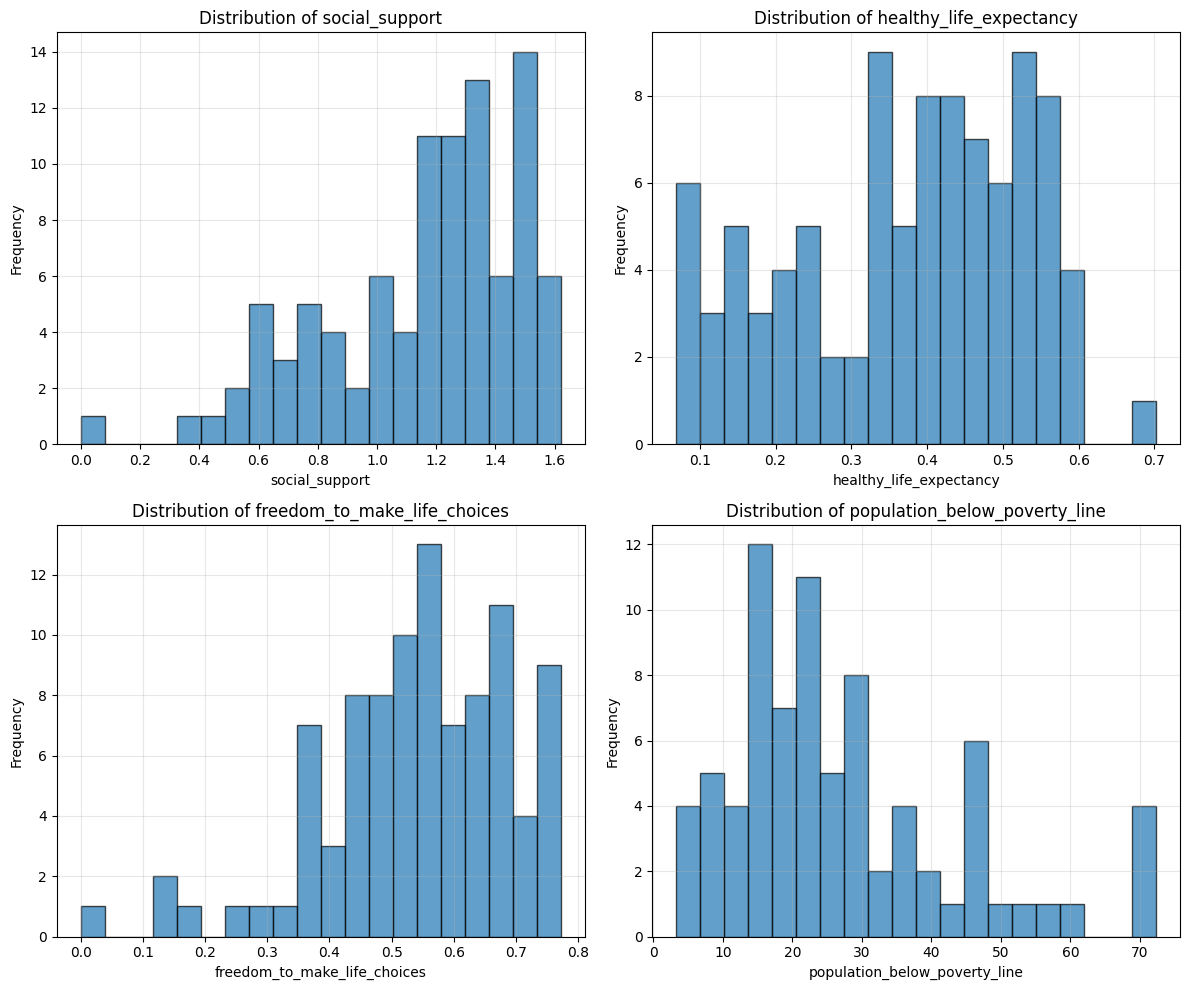

In [8]:
important_features = ['social_support', 'healthy_life_expectancy', 'freedom_to_make_life_choices', 'population_below_poverty_line']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(important_features):
    axes[i].hist(X_train[feature].dropna(), bins=20, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

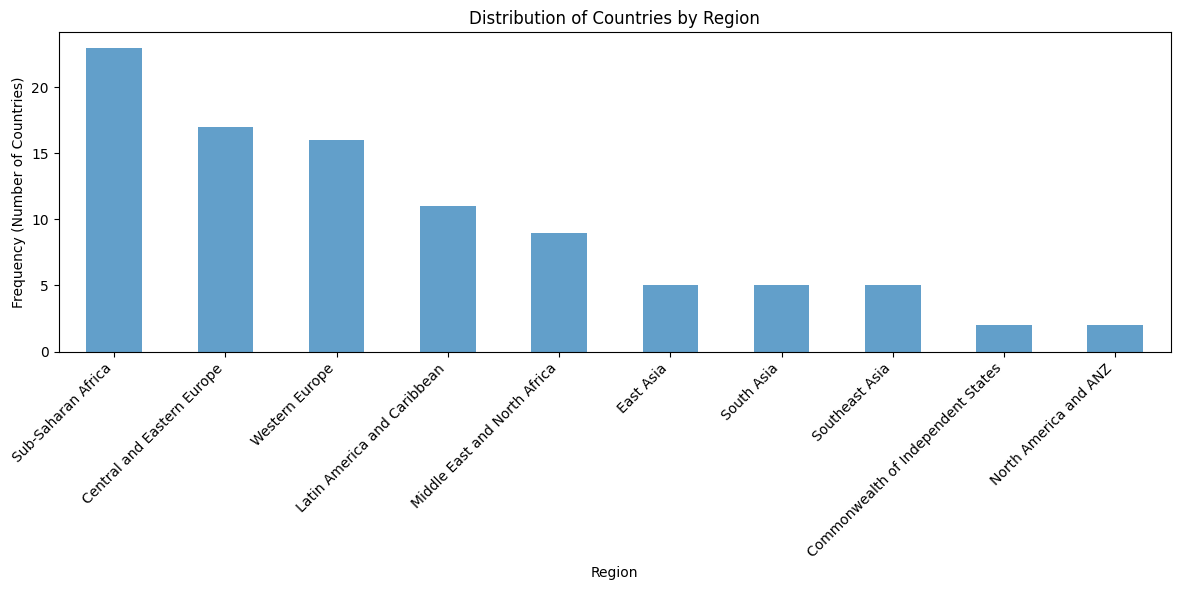

In [9]:
region_counts = X_train['region'].value_counts()

plt.figure(figsize=(12, 6))
region_counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Region')
plt.ylabel('Frequency (Number of Countries)')
plt.title('Distribution of Countries by Region')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

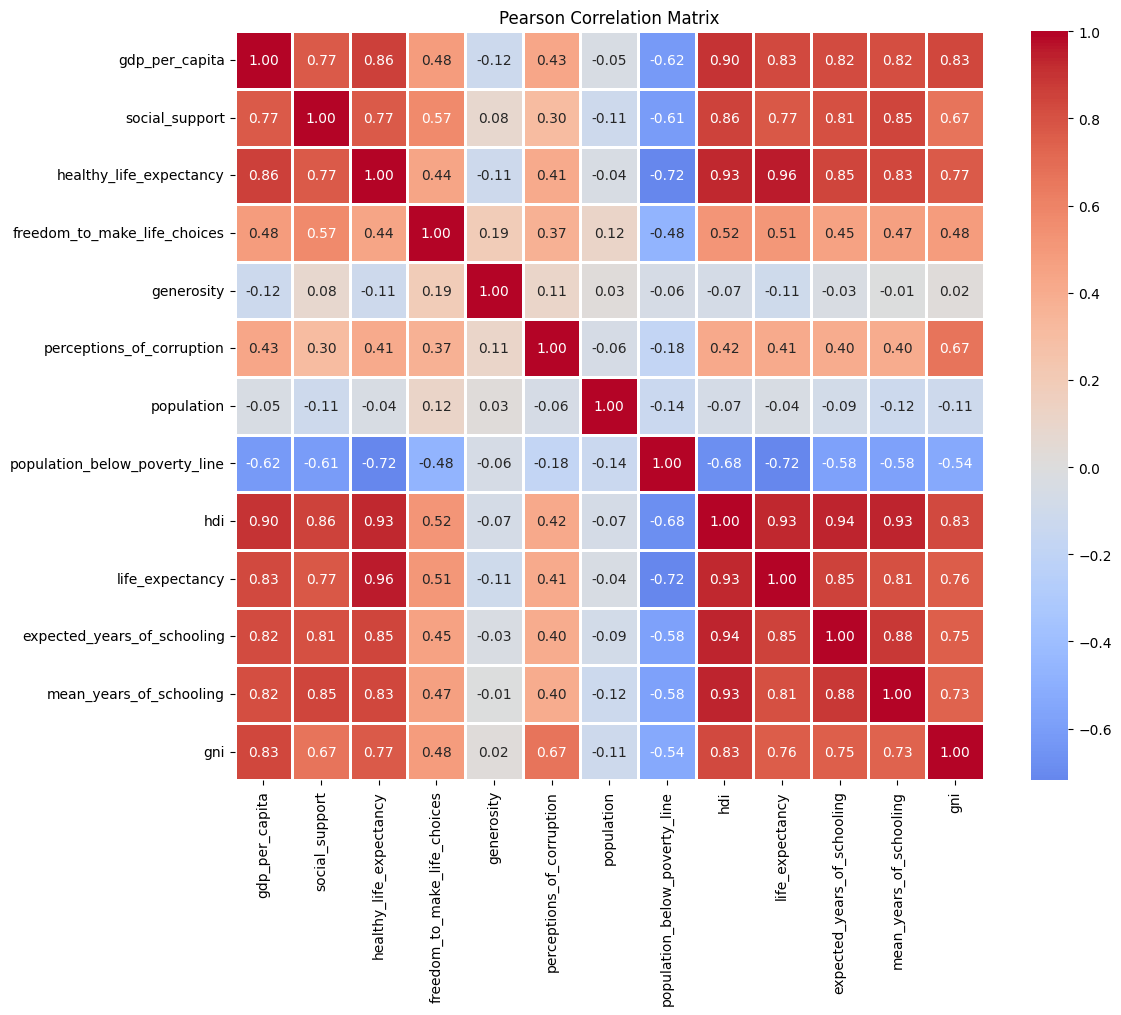

In [10]:
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

pearson_corr = X_train[numerical_cols].corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Pearson Correlation Matrix')
plt.tight_layout()
plt.show()

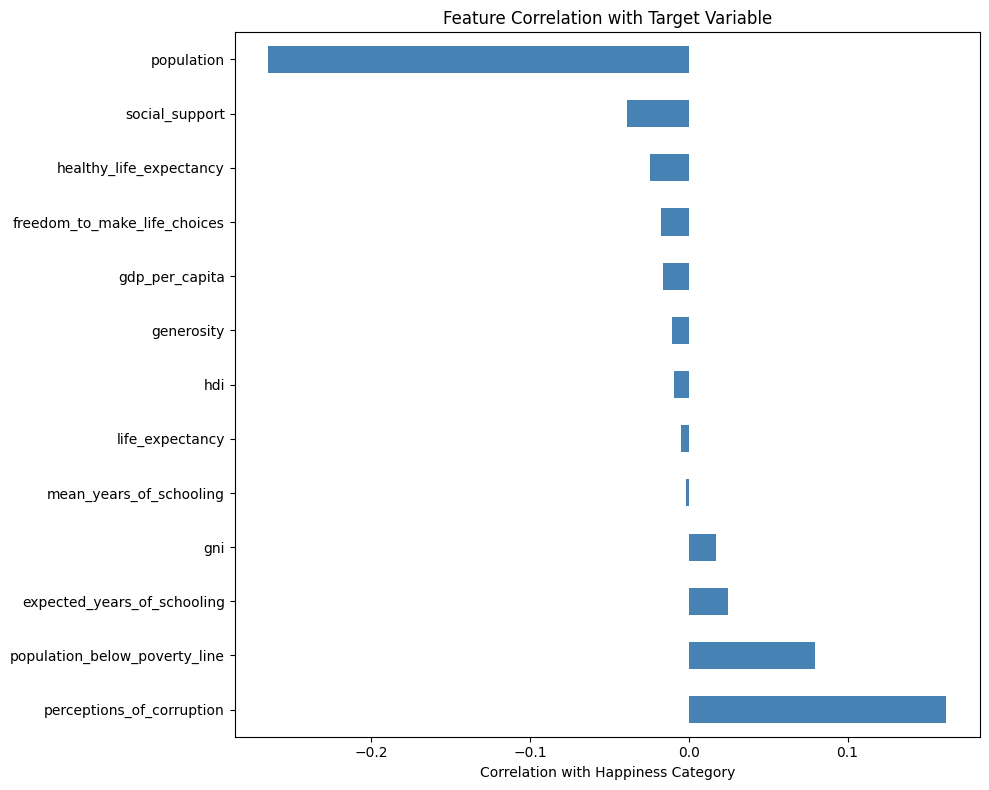

perceptions_of_corruption        0.162115
population_below_poverty_line    0.079533
expected_years_of_schooling      0.024791
gni                              0.017251
mean_years_of_schooling         -0.001661
life_expectancy                 -0.004647
hdi                             -0.009183
generosity                      -0.010237
gdp_per_capita                  -0.016241
freedom_to_make_life_choices    -0.017659
healthy_life_expectancy         -0.024684
social_support                  -0.038729
population                      -0.264719
Name: happiness_category, dtype: float64


In [11]:
temp_df = X_train[numerical_cols].copy()
temp_df['happiness_category'] = y_train_labels

target_correlation = temp_df.corr()['happiness_category'].sort_values(ascending=False)

target_correlation = target_correlation.drop('happiness_category')

plt.figure(figsize=(10, 8))
target_correlation.plot(kind='barh', color='steelblue')
plt.xlabel('Correlation with Happiness Category')
plt.title('Feature Correlation with Target Variable')
plt.tight_layout()
plt.show()

print(target_correlation)

Top 4 features: ['population', 'perceptions_of_corruption', 'population_below_poverty_line', 'social_support']


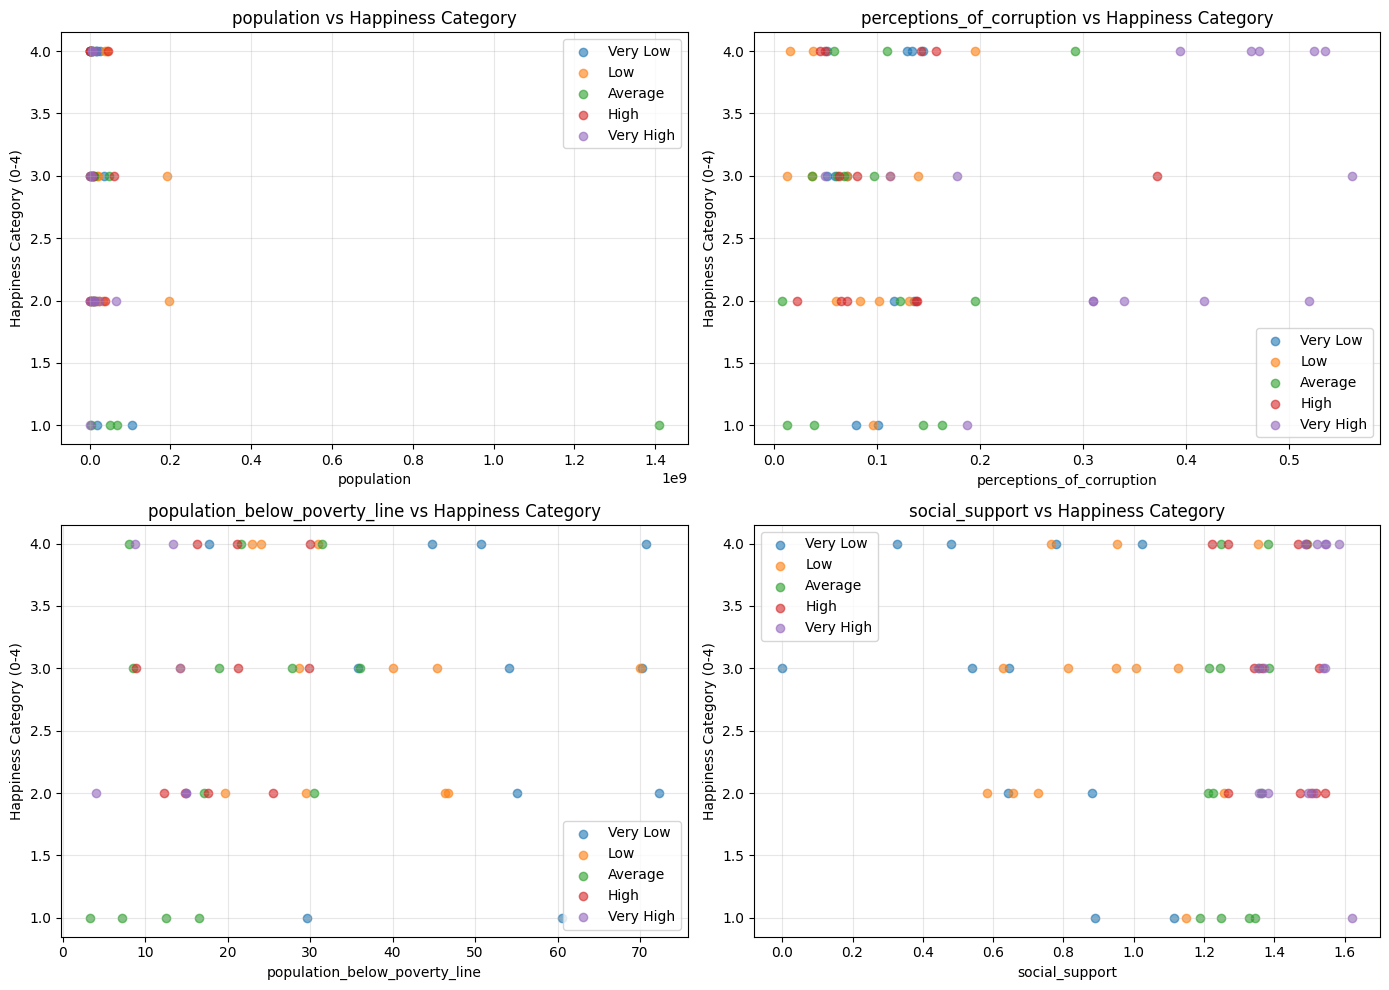

In [12]:
temp_df = X_train.select_dtypes(include=['float64', 'int64']).copy()
temp_df['happiness_category'] = y_train_labels

target_correlation = temp_df.corr()['happiness_category'].sort_values(ascending=False)
target_correlation = target_correlation.drop('happiness_category')

top_features = target_correlation.abs().nlargest(4).index.tolist()

print("Top 4 features:", top_features)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_data = X_train[top_features].copy()
plot_data['category'] = y_train.values
plot_data['category_code'] = y_train_labels

for i, feature in enumerate(top_features):
    for category in plot_data['category'].unique():
        subset = plot_data[plot_data['category'] == category]
        axes[i].scatter(subset[feature], subset['category_code'],
                       label=category, alpha=0.6)

    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Happiness Category (0-4)')
    axes[i].set_title(f'{feature} vs Happiness Category')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

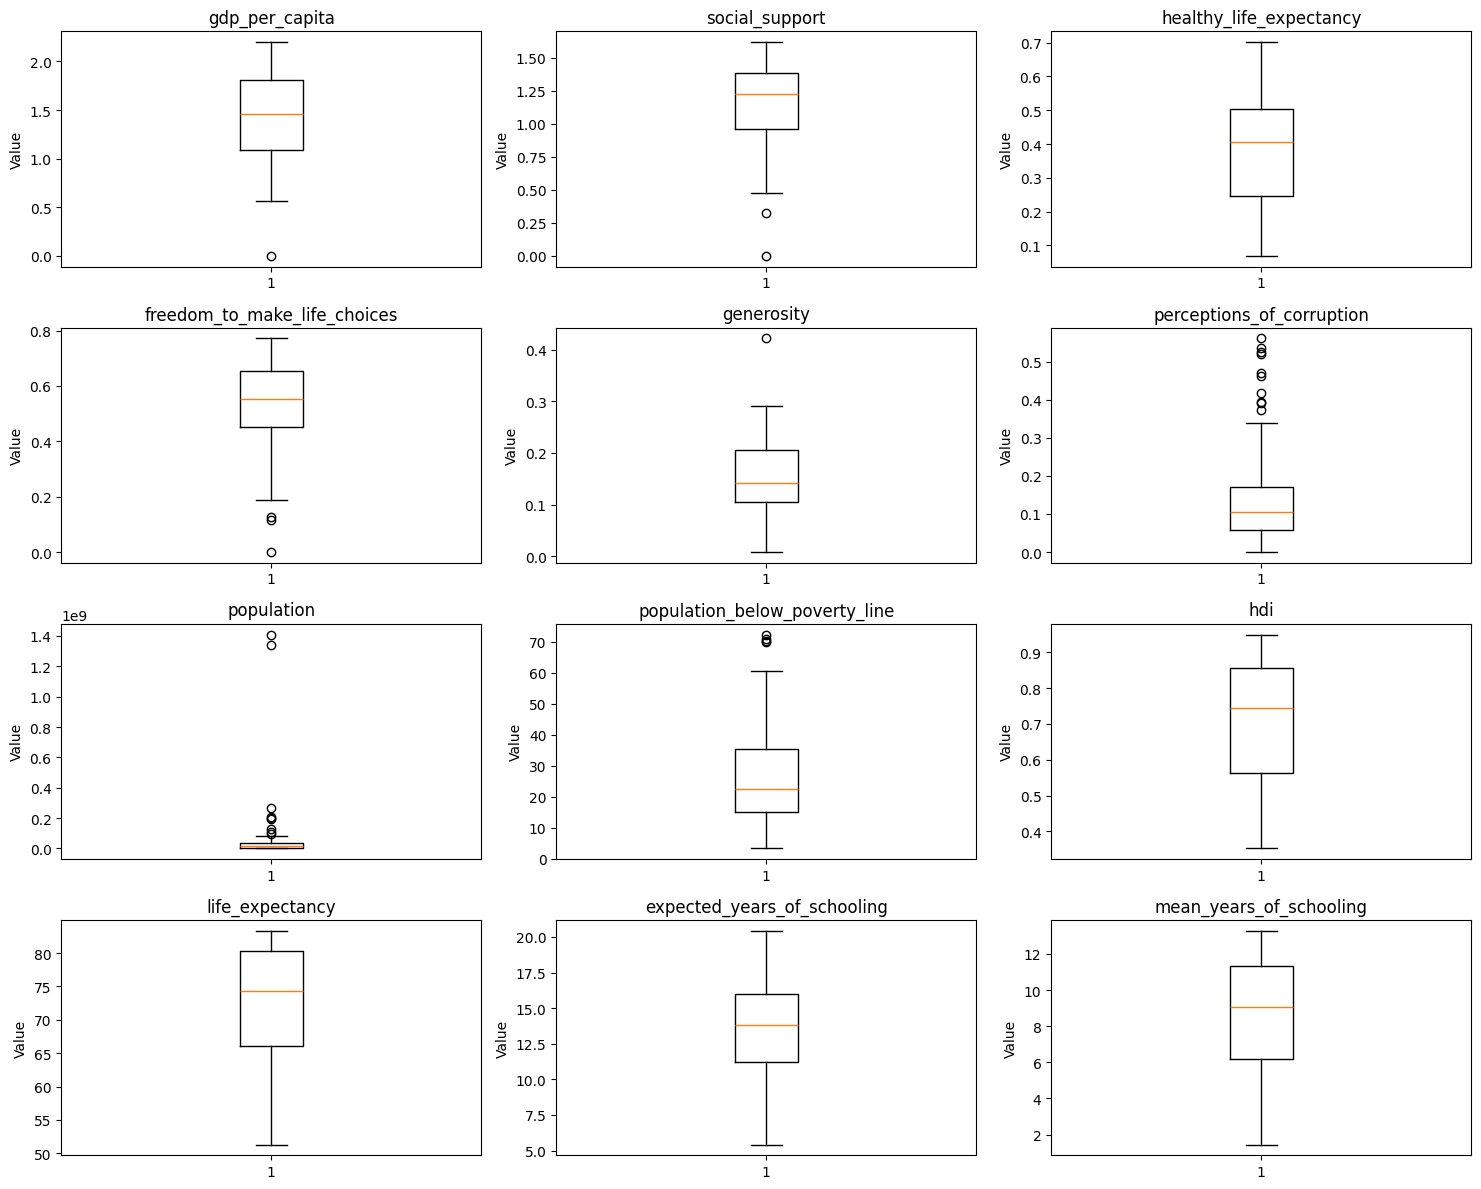

In [13]:
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if i < len(axes):
        axes[i].boxplot(X_train[col].dropna(), vert=True)
        axes[i].set_title(col)
        axes[i].set_ylabel('Value')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [14]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outlier_summary = []

for col in numerical_cols:
    outliers, lower, upper = detect_outliers_iqr(X_train, col)
    outlier_summary.append({
        'Feature': col,
        'Outlier_Count': len(outliers),
        'Outlier_Percentage': (len(outliers) / len(X_train)) * 100,
        'Lower_Bound': lower,
        'Upper_Bound': upper
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.sort_values('Outlier_Count', ascending=False))

                          Feature  Outlier_Count  Outlier_Percentage  \
5       perceptions_of_corruption             10           10.526316   
6                      population              9            9.473684   
7   population_below_poverty_line              4            4.210526   
3    freedom_to_make_life_choices              3            3.157895   
1                  social_support              2            2.105263   
12                            gni              2            2.105263   
0                  gdp_per_capita              1            1.052632   
4                      generosity              1            1.052632   
2         healthy_life_expectancy              0            0.000000   
8                             hdi              0            0.000000   
9                 life_expectancy              0            0.000000   
10    expected_years_of_schooling              0            0.000000   
11        mean_years_of_schooling              0            0.00

# 4. Feature Engineering

In [15]:
X_train['log_population'] = np.log1p(X_train['population'])
X_test['log_population'] = np.log1p(X_test['population'])

X_train['log_poverty'] = np.log1p(X_train['population_below_poverty_line'])
X_test['log_poverty'] = np.log1p(X_test['population_below_poverty_line'])

X_train['log_gdp'] = np.log1p(X_train['gdp_per_capita'])
X_test['log_gdp'] = np.log1p(X_test['gdp_per_capita'])

X_train = X_train.drop(columns=['population', 'population_below_poverty_line', 'gdp_per_capita'])
X_test = X_test.drop(columns=['population', 'population_below_poverty_line', 'gdp_per_capita'])

X_train['social_freedom'] = X_train['social_support'] * X_train['freedom_to_make_life_choices']
X_test['social_freedom'] = X_test['social_support'] * X_test['freedom_to_make_life_choices']

temp_df = X_train[['social_freedom']].copy()
temp_df['happiness'] = y_train_labels

correlation_matrix = temp_df.corr()
interaction_corr = correlation_matrix['happiness'].sort_values(ascending=False)

print(interaction_corr)

happiness         1.000000
social_freedom    0.012221
Name: happiness, dtype: float64


In [16]:
numeric_features = X_train.select_dtypes(include=['float64', 'int64'])
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])

preprocess=preprocessor.fit(X_train)

In [17]:
def preprocessor(data):
    data = data.drop(['country', 'country_name'], axis=1, errors='ignore')
    preprocessed_data = preprocess.transform(data)
    return preprocessed_data

# 5. Model Development & Comparison

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best mean cross-validation score: 0.600
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}

Test set accuracy: 0.5476 (54.76%)
              precision    recall  f1-score   support

    Very Low       0.50      0.33      0.40         9
         Low       0.27      0.38      0.32         8
     Average       0.62      0.62      0.62         8
        High       0.60      0.75      0.67         8
   Very High       0.86      0.67      0.75         9

    accuracy                           0.55        42
   macro avg       0.57      0.55      0.55        42
weighted avg       0.58      0.55      0.55        42



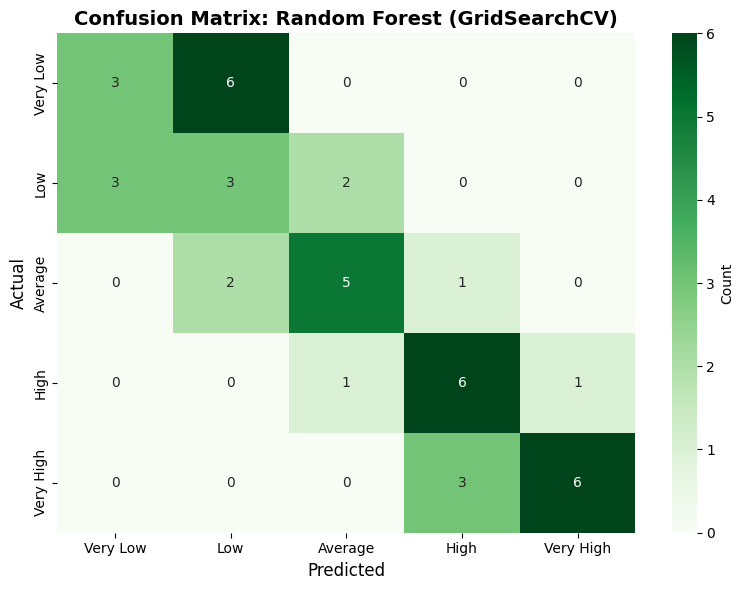

Random Forest GridSearchCV Test Accuracy: 0.5476


In [31]:
param_grid = {
    'n_estimators': [30, 50, 70, 100],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


gridmodel = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

X_train_clean = X_train.drop(['country', 'country_name'], axis=1, errors='ignore')
X_test_clean = X_test.drop(['country', 'country_name'], axis=1, errors='ignore')

gridmodel.fit(preprocess.transform(X_train_clean), y_train_labels)

print(f"Best mean cross-validation score: {gridmodel.best_score_:.3f}")
print(f"Best parameters: {gridmodel.best_params_}")

test_score = gridmodel.score(preprocess.transform(X_test_clean), y_test_labels)
print(f"\nTest set accuracy: {test_score:.4f} ({test_score*100:.2f}%)")

prediction_labels = gridmodel.predict(preprocess.transform(X_test_clean))

print(classification_report(y_test_labels, prediction_labels,
                          target_names=['Very Low', 'Low', 'Average', 'High', 'Very High']))

cm = confusion_matrix(y_test_labels, prediction_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Very Low', 'Low', 'Average', 'High', 'Very High'],
            yticklabels=['Very Low', 'Low', 'Average', 'High', 'Very High'],
            cbar_kws={'label': 'Count'})

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix: Random Forest (GridSearchCV)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

rf_gridcv_accuracy = test_score

print(f"Random Forest GridSearchCV Test Accuracy: {rf_gridcv_accuracy:.4f}")

Test set accuracy: 0.5476 (54.76%)
              precision    recall  f1-score   support

    Very Low       0.50      0.44      0.47         9
         Low       0.40      0.50      0.44         8
     Average       0.62      0.62      0.62         8
        High       0.50      0.62      0.56         8
   Very High       0.83      0.56      0.67         9

    accuracy                           0.55        42
   macro avg       0.57      0.55      0.55        42
weighted avg       0.58      0.55      0.55        42



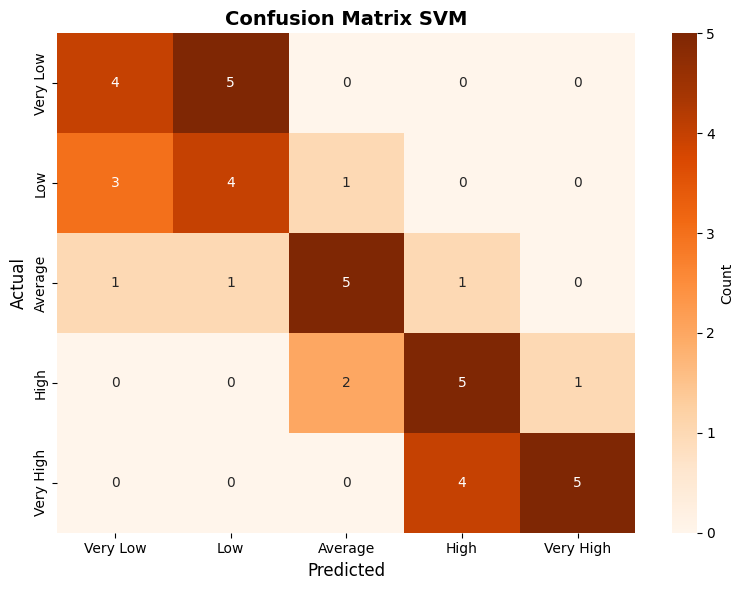

SVM Test Accuracy: 0.5476


In [30]:
svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

X_train_clean = X_train.drop(['country', 'country_name'], axis=1, errors='ignore')
X_test_clean = X_test.drop(['country', 'country_name'], axis=1, errors='ignore')

svm_model.fit(preprocess.transform(X_train_clean), y_train_labels)

svm_predictions = svm_model.predict(preprocess.transform(X_test_clean))

svm_accuracy = accuracy_score(y_test_labels, svm_predictions)

print(f"Test set accuracy: {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%)")

print(classification_report(y_test_labels, svm_predictions,
                          target_names=['Very Low', 'Low', 'Average', 'High', 'Very High']))

cm = confusion_matrix(y_test_labels, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Very Low', 'Low', 'Average', 'High', 'Very High'],
            yticklabels=['Very Low', 'Low', 'Average', 'High', 'Very High'],
            cbar_kws={'label': 'Count'})

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix SVM', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"SVM Test Accuracy: {svm_accuracy:.4f}")


Number of features: 24


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,861 (69.77 KB)

 Trainable params: 17,861 (69.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.2520 - loss: 1.5880 - val_accuracy: 0.3333 - val_loss: 1.5521
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4150 - loss: 1.4517 - val_accuracy: 0.3333 - val_loss: 1.5096
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5297 - loss: 1.3399 - val_accuracy: 0.2917 - val_loss: 1.4721
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5608 - loss: 1.2175 - val_accuracy: 0.2500 - val_loss: 1.4402
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4468 - loss: 1.1847 - val_accuracy: 0.3333 - val_loss: 1.4074
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6654 - loss: 1.0374 - val_accuracy: 0.3333 - val_loss: 1.3813
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6196 - loss: 0.9645 - val_accuracy: 0.3750 - val_loss: 1.3383
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6565 - loss: 0.9411 - val_accuracy: 0.4583 - val_loss: 1.2912

Final Training Accuracy:   1.0000
Final Validation Accuracy: 0.4167
Test set accuracy:         0.5000 (50.00%)
              precision    recall  f1-score   support

    Very Low       0.36      0.44      0.40         9
         Low       0.25      0.25      0.25         8
     Average       0.57      0.50      0.53         8
        High       0.57      0.50      0.53         8
   Very High       0.78      0.78      0.78         9

    accuracy                           0.50        42
   macro avg       0.51      0.49      0.50        42
weighted avg       0.51      0.50      0.50        42



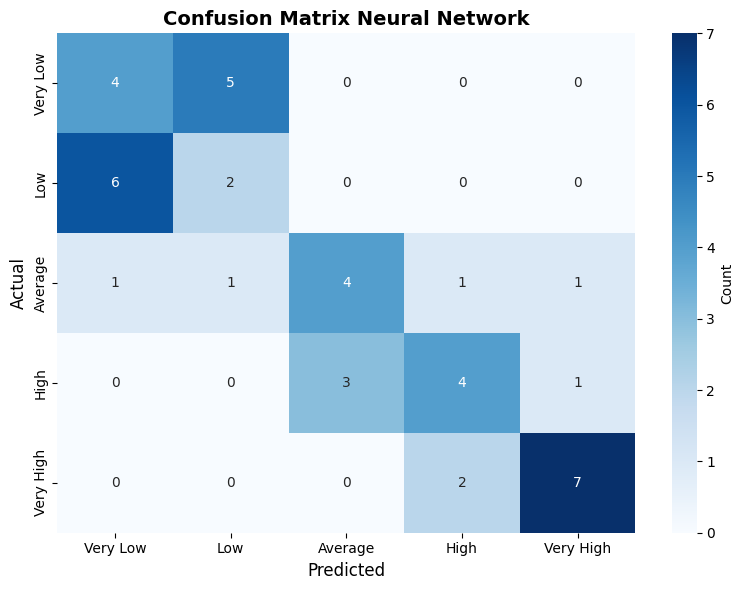

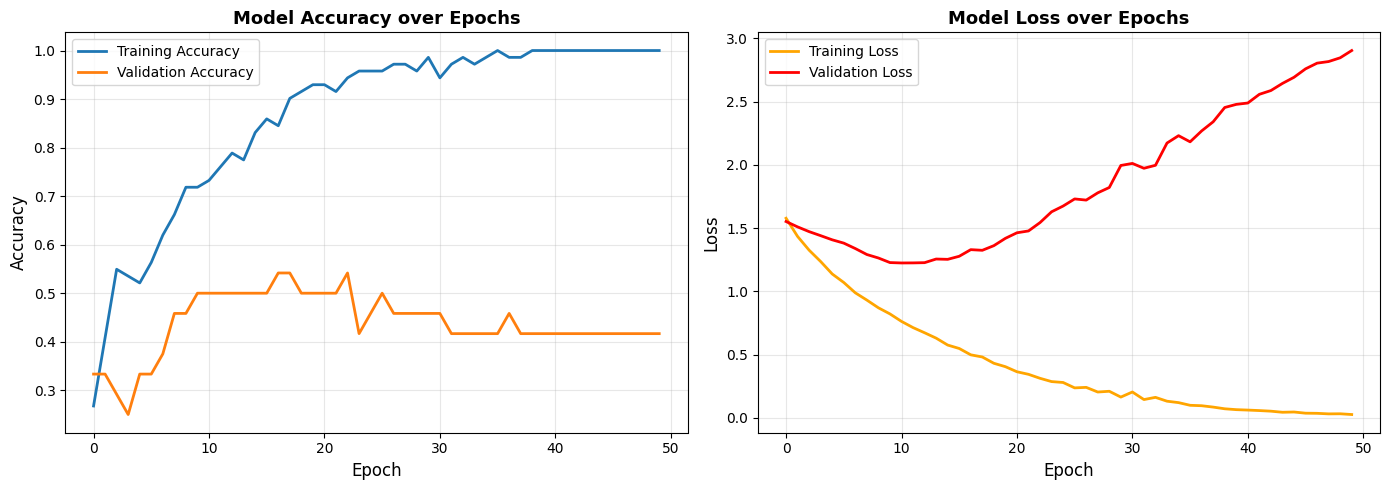

Neural Network Test Accuracy: 0.5000


In [32]:
X_train_clean = X_train.drop(['country', 'country_name'], axis=1, errors='ignore')
X_test_clean = X_test.drop(['country', 'country_name'], axis=1, errors='ignore')

X_train_preprocessed = preprocess.transform(X_train_clean)
X_test_preprocessed = preprocess.transform(X_test_clean)

if hasattr(X_train_preprocessed, 'toarray'):
    X_train_preprocessed = X_train_preprocessed.toarray()
if hasattr(X_test_preprocessed, 'toarray'):
    X_test_preprocessed = X_test_preprocessed.toarray()

feature_count = X_train_preprocessed.shape[1]
print(f"\nNumber of features: {feature_count}")

keras_model = Sequential([
    Dense(128, activation='relu', input_shape=(feature_count,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

keras_model.summary()

keras_model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

y_train_onehot = to_categorical(y_train_labels, num_classes=5)

history = keras_model.fit(
    X_train_preprocessed,
    y_train_onehot,
    batch_size=20,
    epochs=50,
    validation_split=0.25,
    verbose=1
)

y_pred_probs = keras_model.predict(X_test_preprocessed, verbose=0)
nn_predictions = np.argmax(y_pred_probs, axis=1)

nn_accuracy = accuracy_score(y_test_labels, nn_predictions)

print(f"Final Training Accuracy:   {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Test set accuracy:         {nn_accuracy:.4f} ({nn_accuracy*100:.2f}%)")

print(classification_report(y_test_labels, nn_predictions,
                          target_names=['Very Low', 'Low', 'Average', 'High', 'Very High']))

cm = confusion_matrix(y_test_labels, nn_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Very Low', 'Low', 'Average', 'High', 'Very High'],
            yticklabels=['Very Low', 'Low', 'Average', 'High', 'Very High'],
            cbar_kws={'label': 'Count'})

plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix Neural Network', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy over Epochs', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, color='orange')
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss over Epochs', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Neural Network Test Accuracy: {nn_accuracy:.4f}")

Data shape: (42, 24)
Total features: 24
Numeric features: 14
Categorical features: 10

Feature names: ['social_support', 'healthy_life_expectancy', 'freedom_to_make_life_choices', 'generosity', 'perceptions_of_corruption', 'hdi', 'life_expectancy', 'expected_years_of_schooling', 'mean_years_of_schooling', 'gni']...


  0%|          | 0/25 [00:00<?, ?it/s]

<Figure size 1400x1000 with 0 Axes>

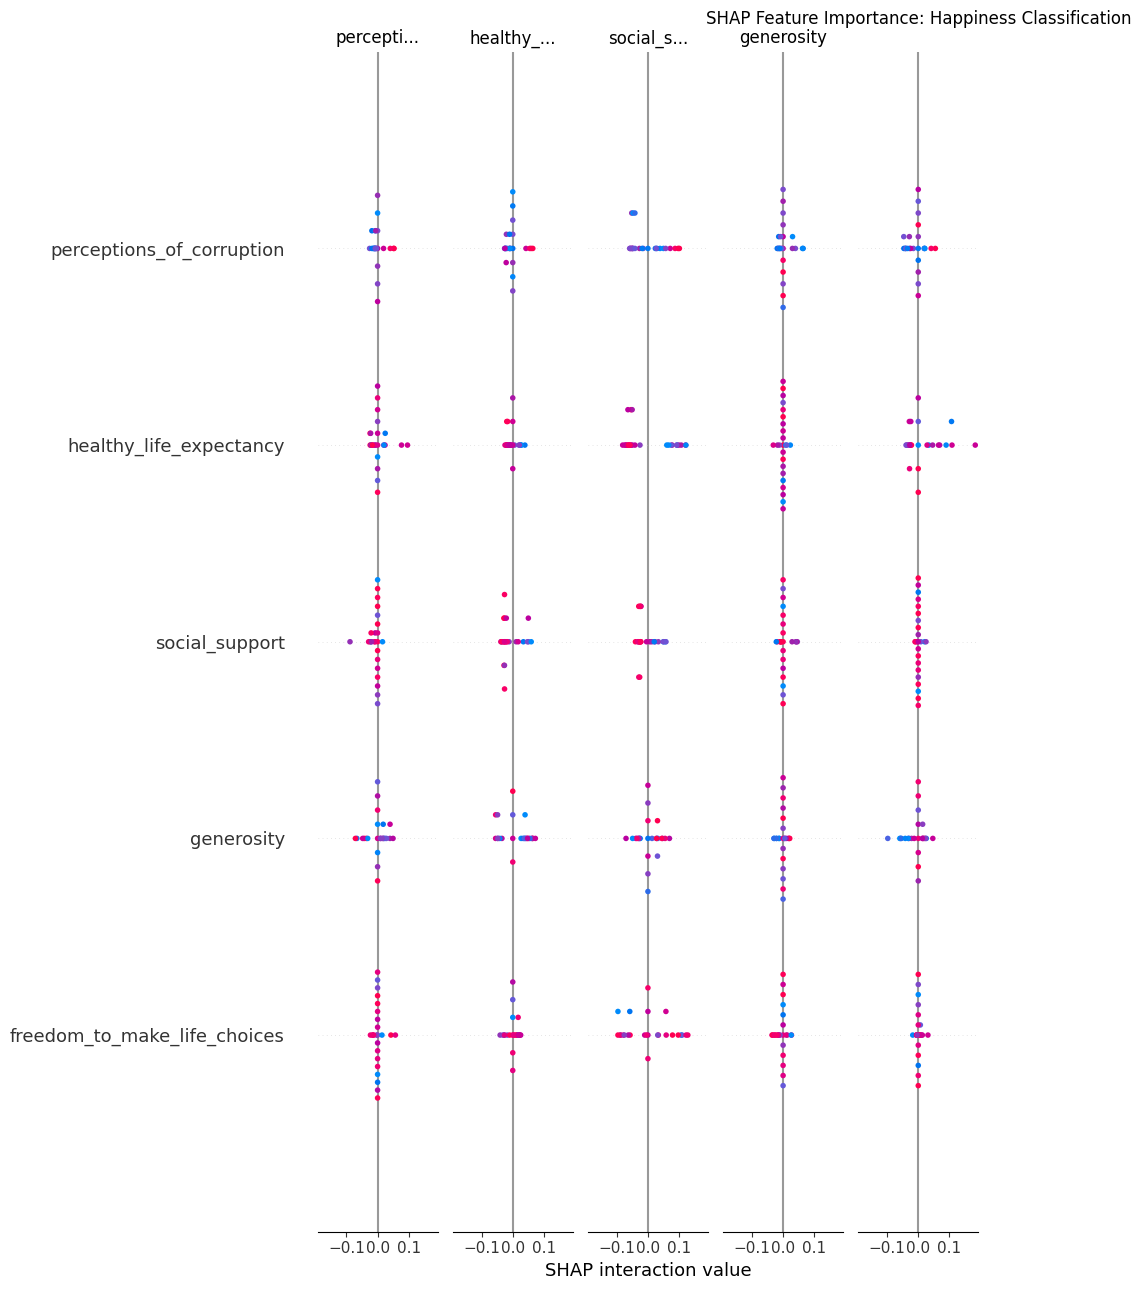

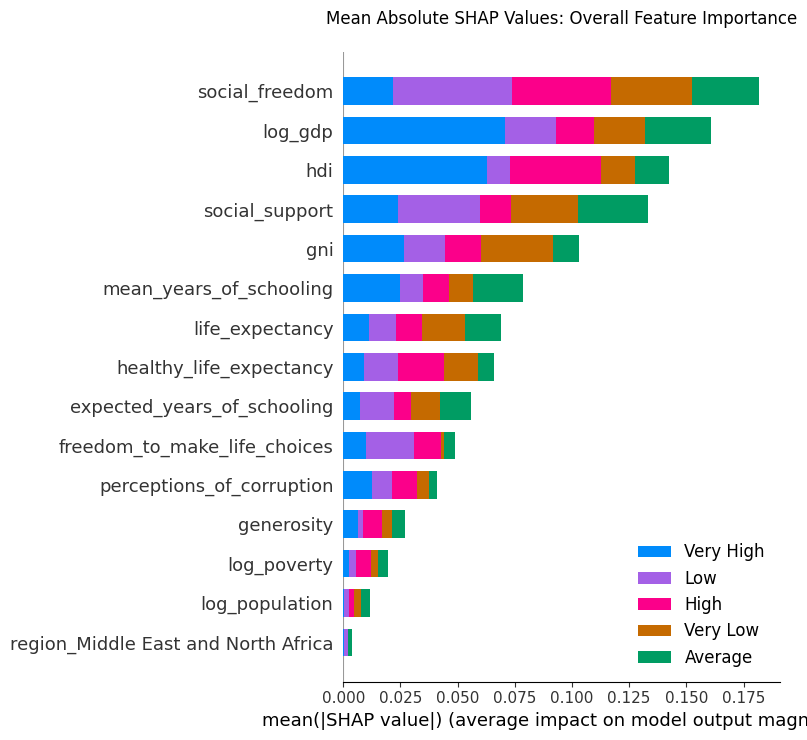

 1. perceptions_of_corruption                     0.012141
 2. healthy_life_expectancy                       0.009617
 3. generosity                                    0.009238
 4. social_support                                0.008645
 5. freedom_to_make_life_choices                  0.008268


In [33]:
X_test_clean = X_test.drop(['country', 'country_name'], axis=1, errors='ignore')
X_test_preprocessed = preprocess.transform(X_test_clean)

if hasattr(X_test_preprocessed, 'toarray'):
    X_test_preprocessed = X_test_preprocessed.toarray()

print(f"Data shape: {X_test_preprocessed.shape}")

numeric_features = X_test_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()

try:
    cat_transformer = preprocess.named_transformers_['cat']
    ohe = cat_transformer.named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(['region']).tolist()
except:
    cat_feature_names = []

all_feature_names = numeric_features + cat_feature_names

print(f"Total features: {len(all_feature_names)}")
print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(cat_feature_names)}")
print(f"\nFeature names: {all_feature_names[:10]}...")

def model_predict(X):
    return gridmodel.predict_proba(X)

background = X_test_preprocessed[:10]

explainer = shap.KernelExplainer(model_predict, background)

n_samples = 25
shap_values = explainer.shap_values(X_test_preprocessed[:n_samples])

plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values,
                  X_test_preprocessed[:n_samples],
                  feature_names=all_feature_names,
                  class_names=['Very Low', 'Low', 'Average', 'High', 'Very High'],
                  max_display=15,
                  show=False)
plt.title('SHAP Feature Importance: Happiness Classification', pad=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values,
                  X_test_preprocessed[:n_samples],
                  feature_names=all_feature_names,
                  plot_type='bar',
                  max_display=15,
                  class_names=['Very Low', 'Low', 'Average', 'High', 'Very High'],
                  show=False)
plt.title('Mean Absolute SHAP Values: Overall Feature Importance', pad=20)
plt.tight_layout()
plt.show()

mean_shap_values = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)

feature_importance = list(zip(all_feature_names, mean_shap_values))
feature_importance.sort(key=lambda x: x[1], reverse=True)

for i, (feature, importance) in enumerate(feature_importance[:15], 1):
    print(f"{i:2d}. {feature:45s} {importance:.6f}")

  0%|          | 0/20 [00:00<?, ?it/s]

<Figure size 1400x1000 with 0 Axes>

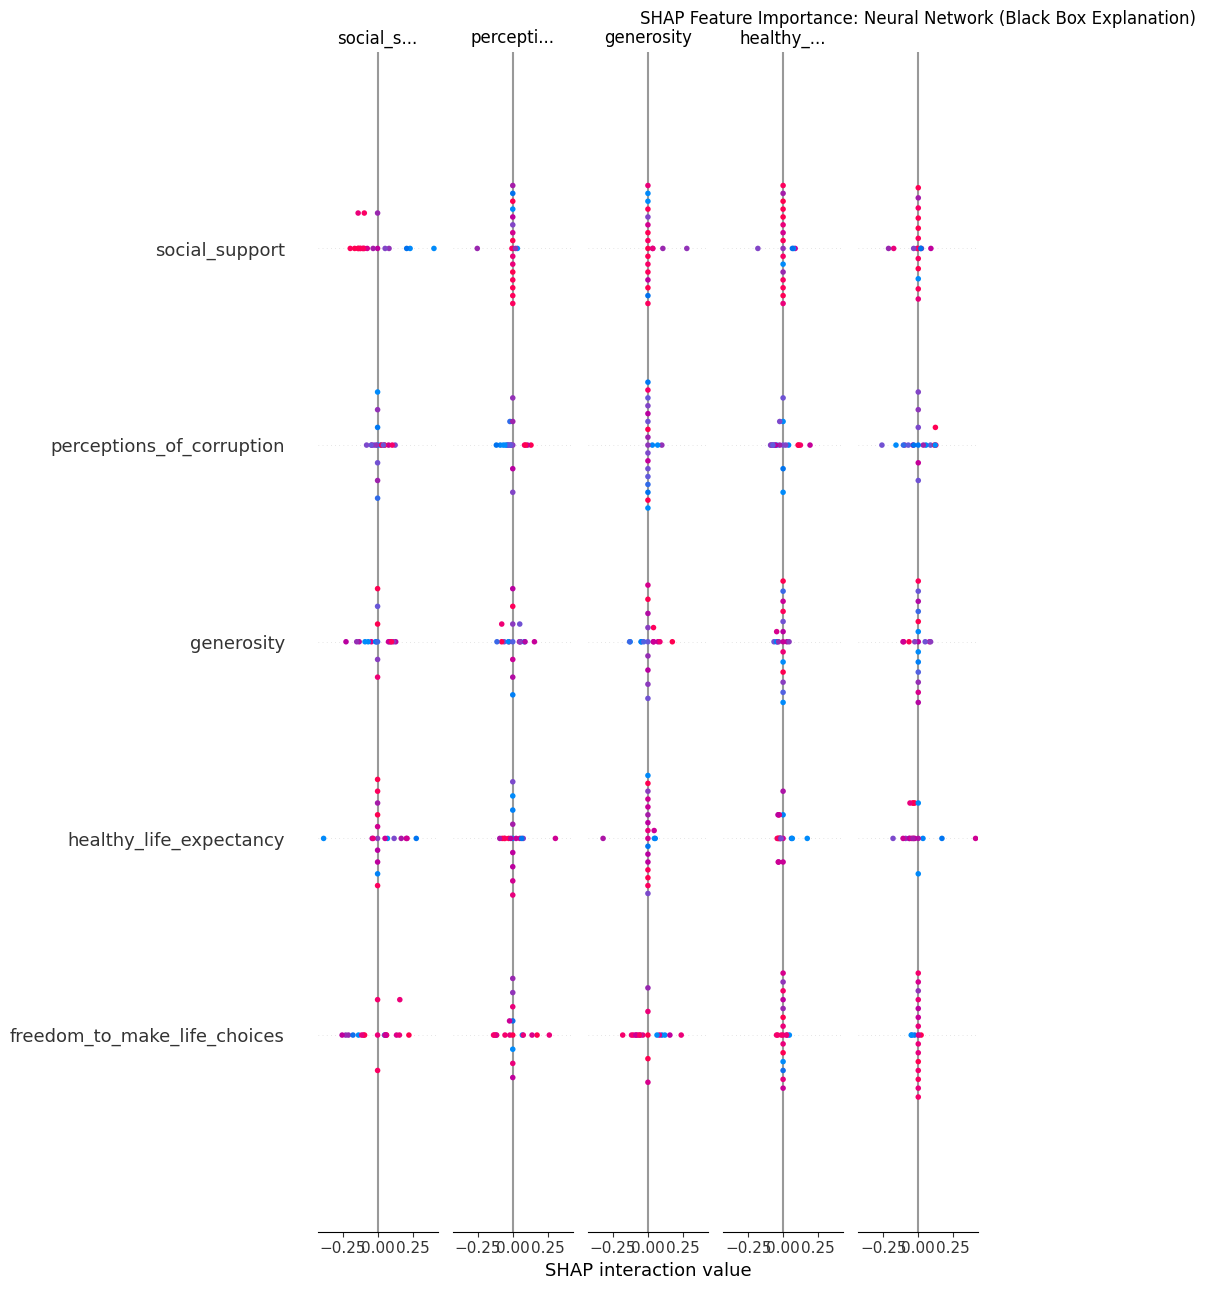

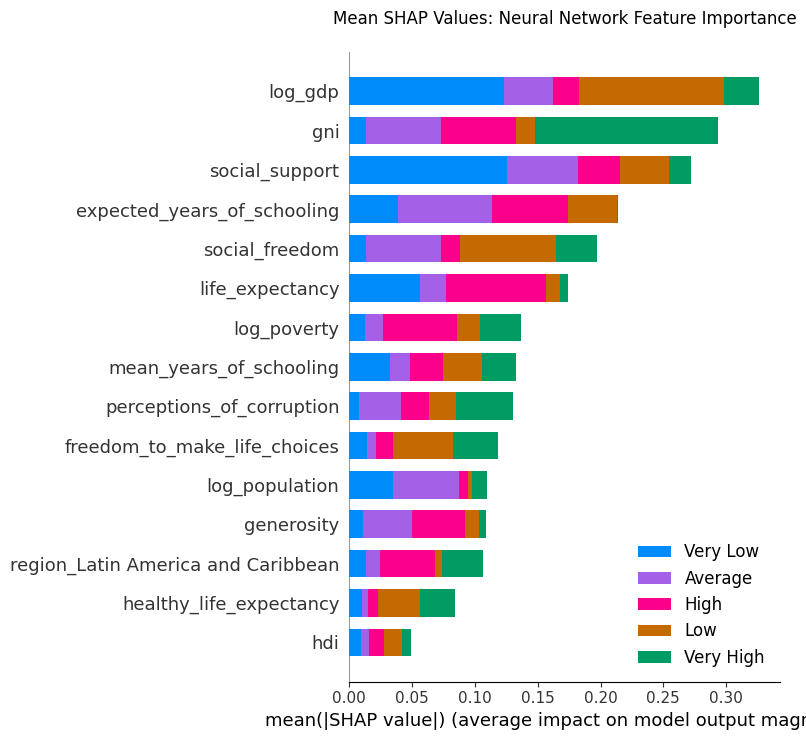

In [34]:
X_train_clean = X_train.drop(['country', 'country_name'], axis=1, errors='ignore')
X_test_clean = X_test.drop(['country', 'country_name'], axis=1, errors='ignore')
X_test_preprocessed = preprocess.transform(X_test_clean)

if hasattr(X_test_preprocessed, 'toarray'):
    X_test_preprocessed = X_test_preprocessed.toarray()

numeric_features = X_test_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()
try:
    cat_transformer = preprocess.named_transformers_['cat']
    ohe = cat_transformer.named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(['region']).tolist()
except:
    cat_feature_names = []
all_feature_names = numeric_features + cat_feature_names

def nn_predict(X):
    return keras_model.predict(X, verbose=0)

background = X_test_preprocessed[:10]
explainer_nn = shap.KernelExplainer(nn_predict, background)

n_samples = 20
shap_values_nn = explainer_nn.shap_values(X_test_preprocessed[:n_samples])

plt.figure(figsize=(14, 10))
shap.summary_plot(shap_values_nn,
                  X_test_preprocessed[:n_samples],
                  feature_names=all_feature_names,
                  class_names=['Very Low', 'Low', 'Average', 'High', 'Very High'],
                  max_display=15,
                  show=False)
plt.title('SHAP Feature Importance: Neural Network (Black Box Explanation)', pad=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_nn,
                  X_test_preprocessed[:n_samples],
                  feature_names=all_feature_names,
                  plot_type='bar',
                  max_display=15,
                  class_names=['Very Low', 'Low', 'Average', 'High', 'Very High'],
                  show=False)
plt.title('Mean SHAP Values: Neural Network Feature Importance', pad=20)
plt.tight_layout()
plt.show()